In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 问题一

## 检查流水号索引数据表

In [2]:
path = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\附表1-检索表格-流水号vs时间.xlsx"
index = pd.read_excel(path)
# index = index.dropna(axis=1,how='all')
col = []
for i in index.columns:
    if 'Unnamed' not in i:
        col.append(i)
data_time = index[col] # 检查时间数据表
data_time = data_time.fillna(0)
dic_time = {}
for i in range(len(list(data_time.index))):
    dic = {}
    da = data_time.iloc[i,:]
    dic['重复次数'] = da['重复次数']
    dic['入院首次检查流水号'] = da['入院首次检查流水号'] 
    dic['入院首次检查时间点'] = da['入院首次检查时间点']
    for j in range(1,14):
        dic[f'随访{j}流水号'] = da[f'随访{j}流水号']
        dic[f'随访{j}时间点'] = da[f'随访{j}时间点']
    dic_time[da['ID']] = dic

In [34]:
path_v = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\表2-患者影像信息血肿及水肿的体积及位置.xlsx"
data_vol = pd.read_excel(path_v)
data_vol = data_vol.dropna(axis=1,how='all')

col_v = list(data_vol.columns)
check_number = []
for i in col_v:
    rule = '[\u4e00-\u9fa5]+.*'
    number = re.findall(rule,i)
    if number != []:
        check_number.append(number[0])
# check_number.append('ID')
# data_vol1 = data_vol[check_number]
# data_vol1.set_index('首次检查流水号',inplace=True)
# data_vol1.set_index('ID',inplace=True)


data_vol.fillna(0,inplace=True)
df_HM_vol = pd.DataFrame([])
df_ED_vol = pd.DataFrame([])
df_HM_per = pd.DataFrame([])
df_ED_per = pd.DataFrame([])

lstHM = []
lstED = []
for i in range(len(check_number)):
    if i < len(check_number) - 1:
        start = check_number[i]
        end = check_number[i+1]
        df = data_vol.loc[:, start:end]
        df = df.iloc[:,0:-1]
#         print(df)     
        df_HM_per[start] = df.iloc[:,3:12].sum(axis=1)
        df_ED_per[start] = df.iloc[:,14:].sum(axis=1)
        lstHM.append(df.iloc[:,0:2])
        lstED.append(pd.concat([df.iloc[:,0],df.iloc[:,12]],axis=1))
    else:
        start = check_number[i]
        df = data_vol.loc[:, start:]
        
        df_HM_per[start] = df.iloc[:,3:12].sum(axis=1)
        df_ED_per[start] = df.iloc[:,14:].sum(axis=1)
        lstHM.append(df.iloc[:,0:2])
        lstED.append(pd.concat([df.iloc[:,0],df.iloc[:,12]],axis=1))
#         print(df)
        
df_ED_vol = pd.concat(lstED,axis=1)
df_HM_vol = pd.concat(lstHM,axis=1)

df_HM_vol['ID'] = data_vol['ID']
df_ED_vol['ID'] = data_vol['ID']


j = 1  # 初始化 j 为 1
lst_aba_vol = []
lst_rel_vol = []

# 血肿体积计算
for i in range(len(check_number)):
    j += 2
    if i >= 1:
        aba = np.where(df_HM_vol[f'HM_volume.{i}'] != 0,df_HM_vol[f'HM_volume.{i}'] - df_HM_vol['HM_volume'],0)
        rel = aba / df_HM_vol['HM_volume']
        lst_aba_vol.append(pd.Series(aba))
        lst_rel_vol.append(pd.Series(rel))
df_aba_vol = pd.concat(lst_aba_vol,axis=1)
df_rel_vol = pd.concat(lst_rel_vol,axis=1)
df_aba_vol.columns = list(range(1,len(check_number)))
df_rel_vol.columns = list(range(1,len(check_number)))
# df_aba_vol.columns = [f'第{i}次检查后绝对体积增加' for i in range(1,len(check_number))]
# df_rel_vol.columns = [f'第{i}次检查后相对体积增加' for i in range(1,len(check_number))]
df_aba_vol.index = list(data_vol['ID'])
df_rel_vol.index = list(data_vol['ID'])

df_aba_vol100 = df_aba_vol.iloc[0:100,:]
df_rel_vol100 = df_rel_vol.iloc[0:100,:]

df_aba_1 = df_aba_vol100[df_aba_vol100 > 6000].dropna(axis=0,how='all')
df_rel_1 = df_rel_vol100[df_rel_vol100 > 0.33].dropna(axis=0,how='all')

lst_1_ = [list(df_aba_1.index),list(df_rel_1.index)]
lst_1_ = [item for i in lst_1_ for item in i]
lst_1 = list(set(lst_1_))


# 计算相对体积和绝对体积各自对应的检查次数
sf_aba_list = []
sf_rel_list = []
for i in lst_1:
    aba = df_aba_vol100.loc[i]
    sf_aba = list(aba[aba > 6000].index)
    if sf_aba != []:
        sf_aba_list.append(min(sf_aba))
    else:
        sf_aba_list.append(None)
    rel = df_rel_vol100.loc[i]
    sf_rel = list(rel[rel > 0.33].index)
    if sf_rel != []:
        sf_rel_list.append(min(sf_rel))
    else:
        sf_rel_list.append(None) 
df_1_ = pd.concat([pd.Series(lst_1),pd.Series(sf_aba_list),pd.Series(sf_rel_list)],axis=1)
df_1_.columns = ['ID','aba','rel']

# 找出它们初次血肿扩张的那次检查
aba_rel_list = []

for i in lst_1:
    # 获取当前 ID 对应的行
    row = df_1_.loc[df_1_['ID'] == i]
    
    # 从当前行中筛选出数字列
    numeric_values = row.select_dtypes(include=['number'])
    
    # 检查是否有数字列
    if not numeric_values.empty:
        min_index = numeric_values.min().min()  # 找到最小值
        aba_rel_list.append(min_index)
    else:
        aba_rel_list.append(None)
df_1 = pd.DataFrame({'ID': lst_1, 'Min_Value': aba_rel_list})

df_1 = df_1.merge(data_vol[['ID', '首次检查流水号']], on='ID', how='left')

first_number_list = list(df_1['首次检查流水号'])
check_number_list = [int(i) for i in list(df_1['Min_Value'])]
time_list = []
for (i,j) in zip(first_number_list,check_number_list):
    for keys,values,in dic_time.items():
        if i == values['入院首次检查流水号']:
            time_list.append([values['入院首次检查时间点'],values[f'随访{j}时间点']])
time_list = [i[1] - i[0] for i in time_list]
df_1.insert(3,'time',time_list)
df_1['time_hours'] = df_1['time'].dt.total_seconds() / 3600
df1 = df_1

path_tabel1 = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\表1-患者列表及临床信息.xlsx"
data1 = pd.read_excel(path_tabel1)
data1.rename(columns={'Unnamed: 0':'ID'},inplace=True)
df1 = df1.merge(data1[['ID', '发病到首次影像检查时间间隔']], on='ID', how='left')
df1['血肿扩张时间'] = df1['time_hours'] + df1['发病到首次影像检查时间间隔']
df1 = df1[df1['血肿扩张时间'] < 48]
df1.insert(7,'是否发生血肿扩张',1)

In [ ]:
ED_vol_list = [i for i in df_ED_vol.columns if i not in check_number]
df_ED_vol[ED_vol_list]

In [136]:
path = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\表4-答案文件.xlsx"
data_answer = pd.read_excel(path)
data_answer.columns = data_answer.loc[0]
data_answer = data_answer.loc[2:]
data_answer.reset_index(inplace=True)
data_answer = data_answer.iloc[:,1:]
data_answer.rename(columns={data_answer.columns[0]:'ID'},inplace=True)

# 使用merge函数将分表的'column_to_merge'列合并到总表中
merged_df = data_answer.merge(df1[['ID', '是否发生血肿扩张','血肿扩张时间']], on='ID', how='left')

# 打印合并后的总表
merged_df['是否发生血肿扩张_y'].fillna(0,inplace=True)
merged_df

,ID,首次影像检查流水号,是否发生血肿扩张_x,血肿扩张时间_x,血肿扩张预测概率,残差（全体）,残差（亚组）,所属亚组,预测mRS（基于首次影像）,预测mRS,是否发生血肿扩张_y,血肿扩张时间_y
0,sub001,20161212002136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,sub002,20160406002131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,sub003,20160413000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.5225
3,sub004,20161215001667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,sub005,20161222000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26.4675
...,...,...,...,...,...,...,...,...,...,...,...,...
155,sub156,20200306000927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
156,sub157,20201009003102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
157,sub158,20200410001952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
158,sub159,20200218000582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [137]:
path_ch = r"C:\Users\10634\Desktop\答案文件_ch.xlsx"
par_data = pd.read_excel(path_ch)

In [138]:
listc = list(par_data['问题1：血肿扩张'])[2:]
listx = list(merged_df['是否发生血肿扩张_y'])
listc100 = listc[0:100]
listx100 = listx[0:100]
listx100 = [int(i) for i in listx100]

In [139]:
idlist100 = list(merged_df['ID'])[0:100]
xc = pd.concat([pd.Series(idlist100),pd.Series(listx100),pd.Series(listc100)],axis=1)
xc[xc.iloc[:,1] != xc.iloc[:,2]]

,0,1,2


# 表4

In [79]:
path = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\表4-答案文件.xlsx"
data_answer = pd.read_excel(path)
data_answer.columns = data_answer.loc[0]
data_answer = data_answer.loc[2:]
data_answer.reset_index(inplace=True)
data_answer = data_answer.iloc[:,1:]
data_answer.rename(columns={data_answer.columns[0]:'ID'},inplace=True)

# 使用merge函数将分表的'column_to_merge'列合并到总表中
merged_df = data_answer.merge(df1[['ID', '是否发生血肿扩张','time_hours']], on='ID', how='left')

# 打印合并后的总表
merged_df

,ID,首次影像检查流水号,是否发生血肿扩张_x,血肿扩张时间,血肿扩张预测概率,残差（全体）,残差（亚组）,所属亚组,预测mRS（基于首次影像）,预测mRS,是否发生血肿扩张_y,time_hours
0,sub001,20161212002136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub002,20160406002131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub003,20160413000006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,7.5225
3,sub004,20161215001667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub005,20161222000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,21.4675
...,...,...,...,...,...,...,...,...,...,...,...,...
155,sub156,20200306000927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,sub157,20201009003102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,sub158,20200410001952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,sub159,20200218000582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 问题二

## a

In [11]:
path2 = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\EDVOL.xlsx"
ed100 = pd.read_excel(path2,sheet_name='b_8次检查时间段')
ed100

D:\anaconda\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Failed to load a conditional formatting rule. It will be discarded. Cause: expected <class 'float'>
  for idx, row in parser.parse():


,ID,首次检查日期,发病至首次检查时间间隔,ED_volume,第一次检查日期,发病至第一次检查时间间隔,ED_volume.1,第二次检查日期,发病至第二次检查时间间隔,ED_volume.2,...,ED_volume.5,第六次检查日期,发病至第六次检查时间间隔,ED_volume.6,第七次检查日期,发病至第七次检查时间间隔,ED_volume.7,第八次检查日期,发病至第八次检查时间间隔,ED_volume.8
0,sub001,2016-12-12 23:32:54,2.5,48919,2016-12-13 05:19:00,8.268333,57898,2016-12-18 09:09:24,132.108333,81747,...,0,NaT,-1.025205e+06,0,NaT,-1.025205e+06,0,NaT,-1.025205e+06,0
1,sub002,2016-04-06 21:21:03,3.0,23526,2016-04-07 09:16:27,14.923333,23390,2016-04-09 15:34:22,69.221944,28415,...,0,NaT,-1.019202e+06,0,NaT,-1.019202e+06,0,NaT,-1.019202e+06,0
2,sub003,2016-04-13 01:18:17,2.0,32621,2016-04-13 08:49:38,9.522500,41292,2016-04-14 14:54:02,39.595833,49767,...,0,NaT,-1.019351e+06,0,NaT,-1.019351e+06,0,NaT,-1.019351e+06,0
3,sub004,2016-12-15 22:53:41,1.0,22191,2016-12-16 14:52:08,16.974167,18956,2016-12-19 09:44:24,83.845278,9540,...,0,NaT,-1.025278e+06,0,NaT,-1.025278e+06,0,NaT,-1.025278e+06,0
4,sub005,2016-12-22 13:18:48,5.0,47392,2016-12-23 10:46:51,26.467500,23182,2016-12-26 10:15:23,97.943056,12898,...,0,NaT,-1.025432e+06,0,NaT,-1.025432e+06,0,NaT,-1.025432e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,sub096,2018-08-02 19:28:50,1.0,5951,2018-08-03 08:14:31,13.761389,6094,2018-08-06 10:27:39,87.980278,9911,...,0,NaT,-1.039554e+06,0,NaT,-1.039554e+06,0,NaT,-1.039554e+06,0
96,sub097,2018-10-10 09:21:10,3.0,10227,2018-10-11 14:16:42,31.925556,8635,2018-10-17 09:45:11,171.400278,1316,...,0,NaT,-1.041198e+06,0,NaT,-1.041198e+06,0,NaT,-1.041198e+06,0
97,sub098,2018-06-12 22:32:20,2.5,39868,2018-06-14 14:47:44,42.756667,29007,2018-06-20 15:41:45,187.656944,26426,...,0,NaT,-1.038332e+06,0,NaT,-1.038332e+06,0,NaT,-1.038332e+06,0
98,sub099,2018-06-20 19:03:09,3.0,9653,2018-06-21 09:43:31,17.672778,19517,2018-06-22 10:34:55,42.529444,30933,...,0,NaT,-1.038520e+06,0,NaT,-1.038520e+06,0,NaT,-1.038520e+06,0


In [12]:
df = ed100

panel_data = pd.DataFrame(columns=['个体ID', '日期', '水肿体积', '发病至时间间隔'])

for index, row in df.iterrows():
    ID = row['ID']
    first_date = row['首次检查日期']
    first_interval = row['发病至首次检查时间间隔']
    first_volume = row['ED_volume']
    
    panel_data = panel_data.append({'个体ID': ID, '日期': first_date, '水肿体积': first_volume, '发病至时间间隔': first_interval}, ignore_index=True)
    
    for i,j in zip(['一', '二', '三', '四','五','六','七','八'],range(1,9)):
        check_date = row[f'第{i}次检查日期']
        interval = row[f'发病至第{i}次检查时间间隔']
        volume = row[f'ED_volume.{j}']
        
        if pd.notnull(check_date) and pd.notnull(interval) and pd.notnull(volume):
            panel_data = panel_data.append({'个体ID': ID, '日期': check_date, '水肿体积': volume, '发病至时间间隔': interval}, ignore_index=True)

C:\Users\10634\AppData\Local\Temp\ipykernel_21500\2791516865.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append({'个体ID': ID, '日期': first_date, '水肿体积': first_volume, '发病至时间间隔': first_interval}, ignore_index=True)
C:\Users\10634\AppData\Local\Temp\ipykernel_21500\2791516865.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append({'个体ID': ID, '日期': check_date, '水肿体积': volume, '发病至时间间隔': interval}, ignore_index=True)
C:\Users\10634\AppData\Local\Temp\ipykernel_21500\2791516865.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append({'个体ID': ID, '日期': check_date, '水肿体积': volume, '发病至时间间隔': interval}, ignore_index=True)
C:\Users\10634\AppData

In [16]:
path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a,sheet_name='ed8次检查面板数据')
panel_data

,个体ID,日期,水肿体积,发病至时间间隔
0,sub001,2016-12-12 23:32:54,48919,2.500000
1,sub001,2016-12-13 05:19:00,57898,8.268333
2,sub001,2016-12-18 09:09:24,81747,132.108333
3,sub001,2016-12-23 16:47:09,107793,259.737500
4,sub001,2016-12-30 14:35:12,126558,425.538333
...,...,...,...,...
445,sub099,2018-06-21 09:43:31,19517,17.672778
446,sub099,2018-06-22 10:34:55,30933,42.529444
447,sub100,2018-03-14 04:46:39,7367,0.500000
448,sub100,2018-03-15 15:00:31,6033,34.731111


# 归一化

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# 将面板数据转换为面板数据对象
panel_data.set_index(['个体ID', '日期'], inplace=True)
panel_data.sort_index(level=[0, 1], inplace=True)

# 对目标变量进行归一化处理
scaler = MinMaxScaler()
endog_var = '水肿体积'  # 目标变量
panel_data[endog_var] = scaler.fit_transform(panel_data[[endog_var]])

# 对自变量进行归一化处理
exog_vars = ['发病至时间间隔']  # 自变量列表
panel_data[exog_vars] = scaler.fit_transform(panel_data[exog_vars])

In [49]:
panel_data

水肿体积     发病至时间间隔
个体ID   日期                                     
sub001 2016-12-12 23:32:54   48919    2.500000
       2016-12-13 05:19:00   57898    8.268333
       2016-12-18 09:09:24   81747  132.108333
       2016-12-23 16:47:09  107793  259.737500
       2016-12-30 14:35:12  126558  425.538333
...                            ...         ...
sub099 2018-06-21 09:43:31   19517   17.672778
       2018-06-22 10:34:55   30933   42.529444
sub100 2018-03-14 04:46:39    7367    0.500000
       2018-03-15 15:00:31    6033   34.731111
       2018-03-22 09:30:51    3191  197.236667

[450 rows x 2 columns]

## 高斯模型

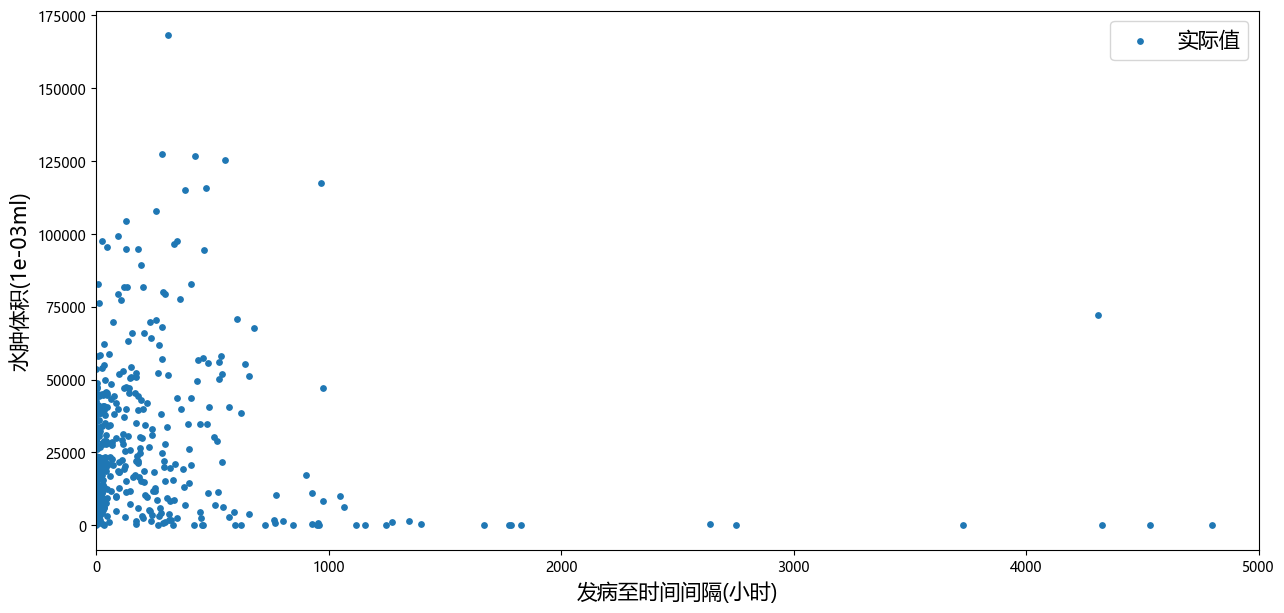

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a,sheet_name='ed8次检查面板数据')
# panel_data = panel_data[panel_data['发病至时间间隔'] < 2000]
# 假设你的面板数据保存在名为panel_data的DataFrame中，包含列'个体ID'、'日期'、'水肿体积'、'发病至时间间隔'等
# 首先，加载面板数据

# 将面板数据转换为面板数据对象
panel_data.set_index(['个体ID', '日期'], inplace=True)
panel_data.sort_index(level=[0, 1], inplace=True)

# 定义高斯分布函数
def gaussian_func(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# 获取拟合所需的自变量和目标变量
x = panel_data['发病至时间间隔'].values.flatten()
y = panel_data['水肿体积'].values.flatten()

# 使用curve_fit进行高斯模型拟合
p0 = [np.mean(x), np.std(x), np.max(y)]  # 初始参数猜测值
params, _ = curve_fit(gaussian_func, x, y, p0=p0)

# 提取拟合参数
mu_gf, sigma_gf, A_gf = params

# # 调整幅度参数和标准差参数
# A_gf *= 4 # 增加幅度参数
# sigma_gf /= 3  # 减小标准差参数

# 生成拟合曲线
x_gf = np.linspace(np.min(x), np.max(x), 450)
y_gf = gaussian_func(x_gf, mu_gf, sigma_gf, A_gf)

# 可视化拟合结果
plt.figure(figsize=(15,7))
plt.scatter(x, y,s=15,label='实际值')
# plt.plot(x_gf, y_gf, color='red', label='拟合曲线')
plt.xlabel('发病至时间间隔(小时)',fontdict={'size':15})
plt.ylabel('水肿体积(1e-03ml)',fontdict={'size':15})
plt.xlim(0,5000)

# plt.title('高斯模型拟合结果')
plt.legend(fontsize=15)
plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\a\水肿进展曲线(8次全记录).jpg')
plt.show()

In [101]:
panel_data

水肿体积     发病至时间间隔
个体ID   日期                                     
sub001 2016-12-12 23:32:54   48919    2.500000
       2016-12-13 05:19:00   57898    8.268333
       2016-12-18 09:09:24   81747  132.108333
       2016-12-23 16:47:09  107793  259.737500
       2016-12-30 14:35:12  126558  425.538333
...                            ...         ...
sub099 2018-06-21 09:43:31   19517   17.672778
       2018-06-22 10:34:55   30933   42.529444
sub100 2018-03-14 04:46:39    7367    0.500000
       2018-03-15 15:00:31    6033   34.731111
       2018-03-22 09:30:51    3191  197.236667

[450 rows x 2 columns]

In [291]:
path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a,sheet_name='ed8次检查面板数据')
error = y - y_gf
error = pd.concat([panel_data['个体ID'],pd.Series(abs(error / 1000))],axis=1)
error.to_excel('./xzl1.xlsx')

In [99]:
panel_data

,个体ID,日期,水肿体积,发病至时间间隔
0,sub001,2016-12-12 23:32:54,48919,2.500000
1,sub001,2016-12-13 05:19:00,57898,8.268333
2,sub001,2016-12-18 09:09:24,81747,132.108333
3,sub001,2016-12-23 16:47:09,107793,259.737500
4,sub001,2016-12-30 14:35:12,126558,425.538333
...,...,...,...,...
411,sub099,2018-06-21 09:43:31,19517,17.672778
412,sub099,2018-06-22 10:34:55,30933,42.529444
413,sub100,2018-03-14 04:46:39,7367,0.500000
414,sub100,2018-03-15 15:00:31,6033,34.731111


array([2.50000000e-01, 4.39547250e+01, 8.76594501e+01, 1.31364175e+02,
       1.75068900e+02, 2.18773625e+02, 2.62478350e+02, 3.06183075e+02,
       3.49887800e+02, 3.93592525e+02, 4.37297250e+02, 4.81001975e+02,
       5.24706700e+02, 5.68411425e+02, 6.12116150e+02, 6.55820875e+02,
       6.99525600e+02, 7.43230325e+02, 7.86935051e+02, 8.30639776e+02,
       8.74344501e+02, 9.18049226e+02, 9.61753951e+02, 1.00545868e+03,
       1.04916340e+03, 1.09286813e+03, 1.13657285e+03, 1.18027758e+03,
       1.22398230e+03, 1.26768703e+03, 1.31139175e+03, 1.35509648e+03,
       1.39880120e+03, 1.44250593e+03, 1.48621065e+03, 1.52991538e+03,
       1.57362010e+03, 1.61732483e+03, 1.66102955e+03, 1.70473428e+03,
       1.74843900e+03, 1.79214373e+03, 1.83584845e+03, 1.87955318e+03,
       1.92325790e+03, 1.96696263e+03, 2.01066735e+03, 2.05437208e+03,
       2.09807680e+03, 2.14178153e+03, 2.18548625e+03, 2.22919098e+03,
       2.27289570e+03, 2.31660043e+03, 2.36030515e+03, 2.40400988e+03,
      

# 多项式回归模型

In [192]:
path2a = r"C:\Users\10634\Desktop\20届华为杯数学建模\E题\竞赛发布数据\2b.xlsx"
panel_data = pd.read_excel(path2a)

,个体ID,日期,水肿体积,发病至时间间隔
0,sub001,2016-12-12 23:32:54,48919,2.500000
1,sub001,2016-12-13 05:19:00,57898,8.268333
2,sub001,2016-12-18 09:09:24,81747,132.108333
3,sub001,2016-12-23 16:47:09,107793,259.737500
4,sub001,2016-12-30 14:35:12,126558,425.538333
...,...,...,...,...
411,sub099,2018-06-21 09:43:31,19517,17.672778
412,sub099,2018-06-22 10:34:55,30933,42.529444
413,sub100,2018-03-14 04:46:39,7367,0.500000
414,sub100,2018-03-15 15:00:31,6033,34.731111


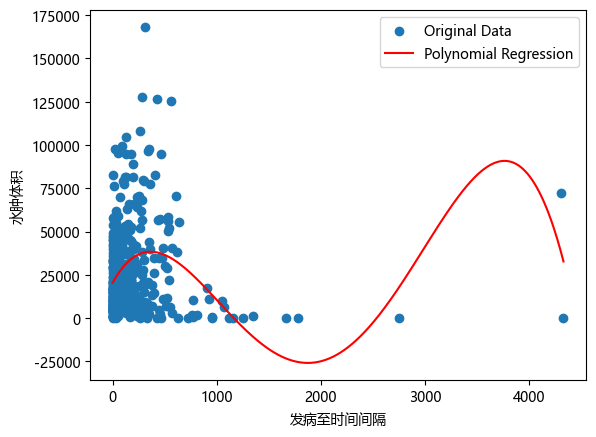

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 读取数据
path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a)
x = panel_data['发病至时间间隔']  # 时间间隔
x = np.array(x)
y = panel_data['水肿体积']  # 水肿体积

# 转换 x 为多项式特征
degree = 4  # 多项式的次数
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(x.reshape(-1, 1))

# 使用线性回归模型拟合多项式特征
model = LinearRegression()
model.fit(x_poly, y)

# 生成用于绘制曲线的数据
x_plot = np.linspace(np.min(x), np.max(x), 1000).reshape(-1, 1)
x_plot_poly = poly_features.transform(x_plot)
y_plot = model.predict(x_plot_poly)

# 绘制原始数据点和拟合曲线
plt.scatter(x, y, label='Original Data')
plt.plot(x_plot, y_plot, 'r-', label='Polynomial Regression')

plt.xlabel('发病至时间间隔')
plt.ylabel('水肿体积')
plt.legend()
plt.show()

## 卡方分布曲线拟合

C:\Users\10634\AppData\Local\Temp\ipykernel_15584\2562162330.py:15: RuntimeWarning: overflow encountered in exp
  return lambd * np.exp(-lambd * x)
C:\Users\10634\AppData\Local\Temp\ipykernel_15584\2562162330.py:15: RuntimeWarning: overflow encountered in multiply
  return lambd * np.exp(-lambd * x)


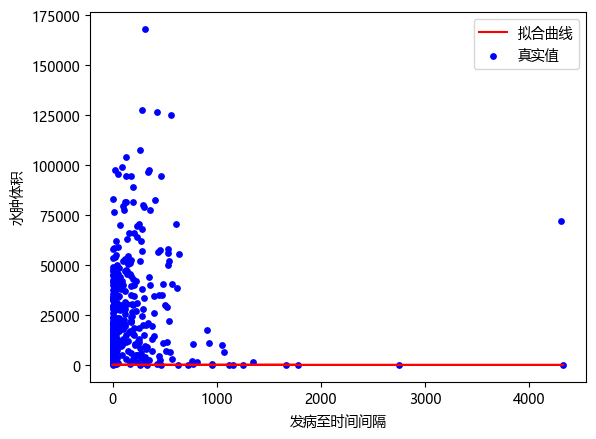

拟合参数 lambda: 0.7176630902067772


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# 读取数据
path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a)
x = panel_data['发病至时间间隔']  # 时间间隔
x = np.array(x)
y = panel_data['水肿体积']  # 水肿体积

# 定义指数分布的拟合函数
def exponential_fit(x, lambd):
    return lambd * np.exp(-lambd * x)

# 使用 curve_fit 进行拟合
params, params_covariance = curve_fit(exponential_fit, xdata=x, ydata=y, p0=[1.0])  # 初始参数值可根据实际情况调整
y_fit = exponential_fit(x, *params)

# 绘制拟合曲线和原始数据散点图
plt.plot(x, y_fit, 'r-', label='拟合曲线')
plt.scatter(x, y, s=15, c='blue', label='真实值')
plt.legend()
plt.xlabel('发病至时间间隔')
plt.ylabel('水肿体积')
plt.show()

# 打印拟合参数
print(f"拟合参数 lambda: {params[0]}")


In [89]:
params

array([   184.83458534,    398.88660995, 168138.        ])

## 随机效应模型

In [80]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a,sheet_name='ed8次检查面板数据')
panel_data.columns = ['ID','date','vol','time']
# 进行随机效应模型建模
model_formula = 'vol ~ time + C(ID)'
model = smf.mixedlm(model_formula, panel_data, groups=panel_data.index.get_level_values(0))
result = model.fit()

# 输出模型结果
print(result.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        vol           
No. Observations:         450            Method:                    REML          
No. Groups:               450            Scale:                     203708611.5797
Min. group size:          1              Log-Likelihood:            -4036.9654    
Max. group size:          1              Converged:                 Yes           
Mean group size:          1.0                                                     
----------------------------------------------------------------------------------
                    Coef.         Std.Err.       z    P>|z|    [0.025     0.975]  
----------------------------------------------------------------------------------
Intercept           85169.046         9032.606  9.429 0.000   67465.464 102872.628
C(ID)[T.sub002]    -61958.535        12769.922 -4.852 0.000  -86987.123 -36929.947
C(ID)[T.sub003]    -43882.0

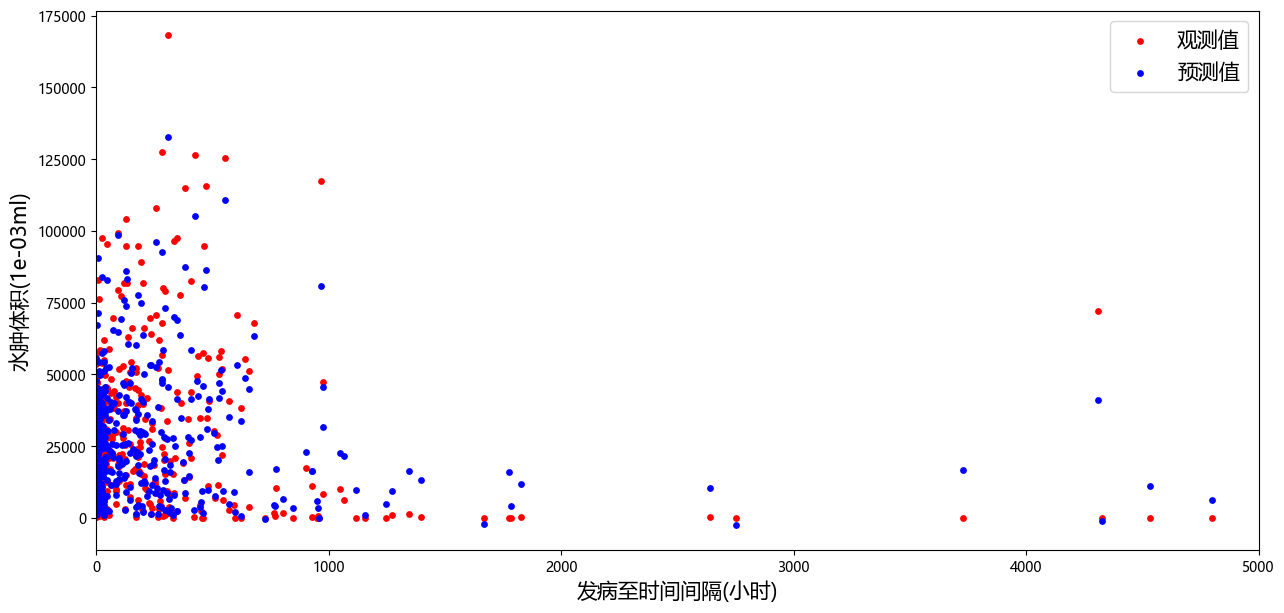

In [89]:
import matplotlib.pyplot as plt

# 获取模型预测值
panel_data['pre'] = result.fittedvalues

# 绘制观测值和预测值的对比图
plt.figure(figsize=(15,7))
plt.scatter(panel_data['time'],panel_data['vol'],s=15, c='red',label='观测值')
plt.scatter(panel_data['time'],panel_data['pre'],s=15, c='blue',label='预测值')
plt.xlabel('发病至时间间隔(小时)',fontdict={'size':15})
plt.ylabel('水肿体积(1e-03ml)',fontdict={'size':15})
plt.xlim(0,5000)
plt.legend(fontsize=15)
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\a\image\随机效应对比图.jpg')
plt.show()
# plt.plot(panel_data['time'],panel_data['pre'], label='预测值')

In [92]:
error_random = panel_data['vol'] - panel_data['pre']
error_guassian = error.iloc[:,1]

In [295]:
path_ans = r"C:\Users\10634\Desktop\20华为杯e题\xzl_答案文件.xlsx"
answer = pd.read_excel(path_ans) 
ero = answer.iloc[2:102,5:7]
ero.columns = ['guassian','random']
ero['ID'] = answer.iloc[2:102,0]
ero

,guassian,random,ID
2,61.811863,12.771957,sub001
3,8.280982,4.998159,sub002
4,11.704094,2.849789,sub003
5,17.990486,3.437651,sub004
6,15.575884,6.570254,sub005
...,...,...,...
97,5.645667,1.586804,sub096
98,6.726,1.931388,sub097
99,30.651,3.928541,sub098
100,20.034333,3.606109,sub099


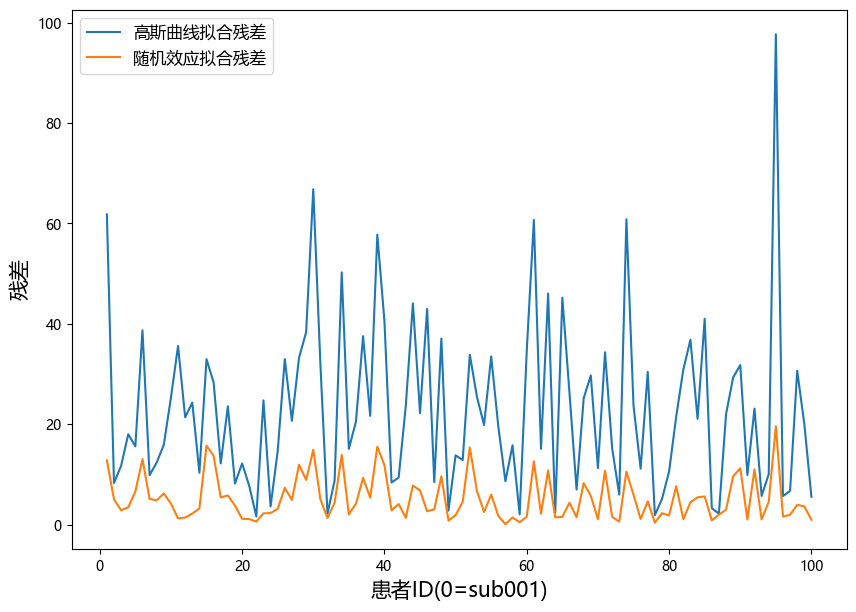

In [296]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1,101), ero['guassian'],label='高斯曲线拟合残差')
plt.plot(np.arange(1,101), ero['random'],label='随机效应拟合残差')
plt.xlabel('患者ID(0=sub001)',fontdict={'size':15})
plt.ylabel('残差',fontdict={'size':15})
plt.legend(fontsize=12)
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\a\image\残差对比图.jpg')
plt.show()

## b

In [175]:
# 读取特征数据
path_reluster = r"C:\Users\10634\Desktop\20华为杯e题\question2\b\聚类特征.xlsx"
data = pd.read_excel(path_reluster)  # 请将'your_data.csv'替换为您的数据文件路径
x = data.iloc[:,1:21]
x

,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,发病到首次影像检查时间间隔,收缩压,舒张压,脑室引流,止血治疗,降颅压治疗,降压治疗,镇静、镇痛治疗,止吐护胃,营养神经
0,43,0,0,0,0,0,0,0,0,0,2.5,180,90,0,1,1,1,1,1,1
1,58,1,0,1,0,0,0,0,0,0,3.0,199,120,0,1,1,1,0,1,1
2,78,1,0,1,0,0,0,0,0,0,2.0,199,120,0,1,1,1,1,1,1
3,70,1,2,1,1,0,0,0,0,0,1.0,186,99,0,1,1,1,0,0,0
4,51,1,0,0,0,0,0,0,0,0,5.0,135,92,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93,0,0,0,0,0,0,0,0,0,1.0,181,76,0,0,0,1,1,1,1
96,83,0,0,1,0,0,0,0,0,0,3.0,170,79,0,1,1,1,1,1,1
97,82,1,0,1,1,1,1,1,1,0,2.5,200,100,0,1,1,1,1,1,1
98,53,1,0,1,0,0,0,0,0,0,3.0,159,91,1,1,1,1,1,1,1


## K均值聚类

,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,发病到首次影像检查时间间隔,收缩压,舒张压,脑室引流,止血治疗,降颅压治疗,降压治疗,镇静、镇痛治疗,止吐护胃,营养神经
0,43,0,0,0,0,0,0,0,0,0,2.5,180,90,0,1,1,1,1,1,1
1,58,1,0,1,0,0,0,0,0,0,3.0,199,120,0,1,1,1,0,1,1
2,78,1,0,1,0,0,0,0,0,0,2.0,199,120,0,1,1,1,1,1,1
3,70,1,2,1,1,0,0,0,0,0,1.0,186,99,0,1,1,1,0,0,0
4,51,1,0,0,0,0,0,0,0,0,5.0,135,92,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93,0,0,0,0,0,0,0,0,0,1.0,181,76,0,0,0,1,1,1,1
96,83,0,0,1,0,0,0,0,0,0,3.0,170,79,0,1,1,1,1,1,1
97,82,1,0,1,1,1,1,1,1,0,2.5,200,100,0,1,1,1,1,1,1
98,53,1,0,1,0,0,0,0,0,0,3.0,159,91,1,1,1,1,1,1,1


In [197]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering,KMeans,Birch,DBSCAN
from sklearn.mixture import GaussianMixture as GMM

# 读取特征数据
path_reluster = r"C:\Users\10634\Desktop\20华为杯e题\question2\b\聚类特征.xlsx"
data = pd.read_excel(path_reluster)  # 请将'your_data.csv'替换为您的数据文件路径
x = data.iloc[:,1:21]
slist = []
alist = []
for i in [3,4,5]:
# 定义KMeans，以及K值
    k = KMeans(n_clusters=i) # K均值
    agg = AgglomerativeClustering(n_clusters=i) # 层次聚类
    bir = Birch(n_clusters=i)
    gmm = GMM(n_components=i)
#     dbscan = DBSCAN(min_samples=15)
    
#     db_result = dbscan.fit_predict(x)
    bir_result = bir.fit_predict(x)
    k_result = k.fit_predict(x)
    agg_result = agg.fit_predict(x)
    gmm_result = gmm.fit_predict(x)
    
    score_g = silhouette_score(x,gmm_result)
    score_b = silhouette_score(x, bir_result)
    score_k = silhouette_score(x, k_result)
    score_a = silhouette_score(x,agg_result)
#     score_d = silhouette_score(x,db_result)
    
#     cd = Counter(db.labels_)
    cg = Counter(gmm.predict(x))
    cb = Counter(bir.labels_)
    ck = Counter(k.labels_)
    ca = Counter(agg.labels_)
    print(f'k均值{i}个类别:{ck}，轮廓系数为{score_k}\n',\
          f'层次聚类{i}个类别:{ca}，轮廓系数为{score_a}\n',\
          f'birch聚类{i}个类别:{cb}，轮廓系数为{score_b}\n'\
          f'gmm聚类{i}个类别:{cg}，轮廓系数为{score_g}'\
         )
    print('-'*20)
    slist.append(score)
    alist.append(score_a)

D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\a

k均值3个类别:Counter({2: 45, 0: 32, 1: 23})，轮廓系数为0.2812618154952633
 层次聚类3个类别:Counter({2: 40, 0: 37, 1: 23})，轮廓系数为0.2605017636371488
 birch聚类3个类别:Counter({2: 40, 0: 37, 1: 23})，轮廓系数为0.2605017636371488
gmm聚类3个类别:Counter({1: 58, 0: 25, 2: 17})，轮廓系数为-0.019375171013653204
--------------------


D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k均值4个类别:Counter({1: 34, 3: 26, 0: 20, 2: 20})，轮廓系数为0.2960445021173017
 层次聚类4个类别:Counter({2: 40, 0: 23, 1: 20, 3: 17})，轮廓系数为0.2657404801256353
 birch聚类4个类别:Counter({2: 40, 0: 23, 1: 20, 3: 17})，轮廓系数为0.2657404801256353
gmm聚类4个类别:Counter({2: 56, 1: 20, 0: 13, 3: 11})，轮廓系数为-0.08011639083475211
--------------------
k均值5个类别:Counter({2: 28, 1: 26, 0: 24, 4: 15, 3: 7})，轮廓系数为0.2792642218118369
 层次聚类5个类别:Counter({2: 40, 0: 20, 1: 17, 3: 17, 4: 6})，轮廓系数为0.25521917330382526
 birch聚类5个类别:Counter({2: 40, 0: 20, 1: 17, 3: 17, 4: 6})，轮廓系数为0.25521917330382526
gmm聚类5个类别:Counter({3: 42, 4: 20, 0: 17, 2: 14, 1: 7})，轮廓系数为0.05514668459827261
--------------------


D:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [122]:
from collections import Counter
from sklearn.cluster import AgglomerativeClustering,KMeans,Birch,DBSCAN

path2a = r"C:\Users\10634\Desktop\20华为杯e题\question2\a\2b.xlsx"
panel_data = pd.read_excel(path2a,sheet_name='ed8次检查面板数据')
path_reluster = r"C:\Users\10634\Desktop\20华为杯e题\question2\b\聚类特征.xlsx"
data = pd.read_excel(path_reluster)  # 请将'your_data.csv'替换为您的数据文件路径
x = data.iloc[:,1:21]

agg = AgglomerativeClustering(4)
agg.fit(x)
data['agg_predict'] = agg.labels_
c = Counter(agg.labels_)
print(c)


n0 = list(data[data['agg_predict'] == 0]['id'])
n1 = list(data[data['agg_predict'] == 1]['id'])
n2 = list(data[data['agg_predict'] == 2]['id'])
n3 = list(data[data['agg_predict'] == 3]['id'])

dfs = {}
for j,name in zip([n0, n1, n2, n3],['n0','n1','n2','n3']):
    nlst = []
    for i in j:  # 将字符串转换为对应的变量
        dot = panel_data[panel_data['个体ID'] == i]
        nlst.append(dot)
    dfs['df_{}'.format(name)] = pd.concat(nlst, axis=0)
    
dfn0,dfn1,dfn2,dfn3 = dfs['df_n0'],dfs['df_n1'],dfs['df_n2'],dfs['df_n3']

Counter({2: 40, 0: 23, 1: 20, 3: 17})


In [324]:
data

,id,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,...,NCCT_original_firstorder_Mean,NCCT_original_firstorder_Median,NCCT_original_firstorder_Minimum,NCCT_original_firstorder_Range,NCCT_original_firstorder_RobustMeanAbsoluteDeviation,NCCT_original_firstorder_RootMeanSquared,NCCT_original_firstorder_Skewness,NCCT_original_firstorder_Uniformity,NCCT_original_firstorder_Variance,agg_predict
0,sub001,43,0,0,0,0,0,0,0,0,...,53.100174,54.277975,2.630186,88.333203,5.421960,54.182743,-0.680312,0.156607,116.141179,2
1,sub002,58,1,0,1,0,0,0,0,0,...,37.252825,37.518627,11.670399,54.126259,3.986374,37.958520,-0.176969,0.132046,53.076248,0
2,sub003,78,1,0,1,0,0,0,0,0,...,35.163065,35.410096,-1.715890,70.139106,5.382112,36.444232,-0.057096,0.128060,91.740851,0
3,sub004,70,1,2,1,1,0,0,0,0,...,30.191045,30.926762,-20.991359,92.048538,6.191501,32.204819,-0.297133,0.145292,125.651157,0
4,sub005,51,1,0,0,0,0,0,0,0,...,45.985845,46.492200,-9.889141,96.821808,6.482624,47.428035,-0.227378,0.146488,134.720581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,sub096,93,0,0,0,0,0,0,0,0,...,44.469975,45.627698,-1.353307,75.353316,4.764270,45.427431,-0.852965,0.155848,86.072788,3
96,sub097,83,0,0,1,0,0,0,0,0,...,49.624525,49.646822,10.589739,69.684072,5.654763,50.616489,-0.047266,0.121547,99.435503,3
97,sub098,82,1,0,1,1,1,1,1,1,...,35.911280,35.494566,-2.467873,98.855412,5.523299,37.597608,0.432499,0.166861,123.960058,0
98,sub099,53,1,0,1,0,0,0,0,0,...,41.019959,41.559362,3.177012,66.837891,4.002934,41.752598,-0.318306,0.159415,60.642372,2


### 亚组0

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pylab import mpl


mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 将面板数据转换为面板数据对象
dfn0.set_index(['个体ID', '日期'], inplace=True)
dfn0.sort_index(level=[0, 1], inplace=True)

In [311]:
x_pre0,y_pre0 = gaussian_fit(dfn0)
x_pre1,y_pre1 = gaussian_fit(dfn1)
x_pre2,y_pre2 = gaussian_fit(dfn2)
x_pre3,y_pre3 = gaussian_fit(dfn3)

In [327]:
dfn0['pre'] = y_pre0
dfn0.reset_index(inplace=True)
dfn1['pre'] = y_pre1
dfn1.reset_index(inplace=True)
dfn2['pre'] = y_pre2
dfn2.reset_index(inplace=True)
dfn3['pre'] = y_pre3
dfn3.reset_index(inplace=True)
df_k_error = pd.concat([dfn0,dfn1,dfn2,dfn3],axis=0)

In [331]:
df_k_error['k_error'] = abs((df_k_error['水肿体积'] - df_k_error['pre']) /1000)
# df_k_error['亚组'] = data['agg_predict']
data.to_excel(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\k均值聚类.xlsx')

In [308]:
# 定义高斯分布函数
def gaussian_func(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def gaussian_fit(df):
    # 获取拟合所需的自变量和目标变量
    x = df['发病至时间间隔'].values.flatten()
    y = df['水肿体积'].values.flatten()

    # 使用curve_fit进行高斯模型拟合
    p0 = [np.mean(x), np.std(x), np.max(y)]  # 初始参数猜测值
    params, _ = curve_fit(gaussian_func, x, y, p0=p0)

    # 提取拟合参数
    mu_gf, sigma_gf, A_gf = params

    # # 调整幅度参数和标准差参数
    # A_gf *= 2 # 增加幅度参数
    # sigma_gf /= 2# 减小标准差参数
    # # mu_gf = mu_gf - mu_gf*0.1

    # 生成拟合曲线
    x_gf = np.linspace(np.min(x), np.max(x), len(y))
    y_gf = gaussian_func(x_gf, mu_gf, sigma_gf, A_gf)
    return x_gf,y_gf

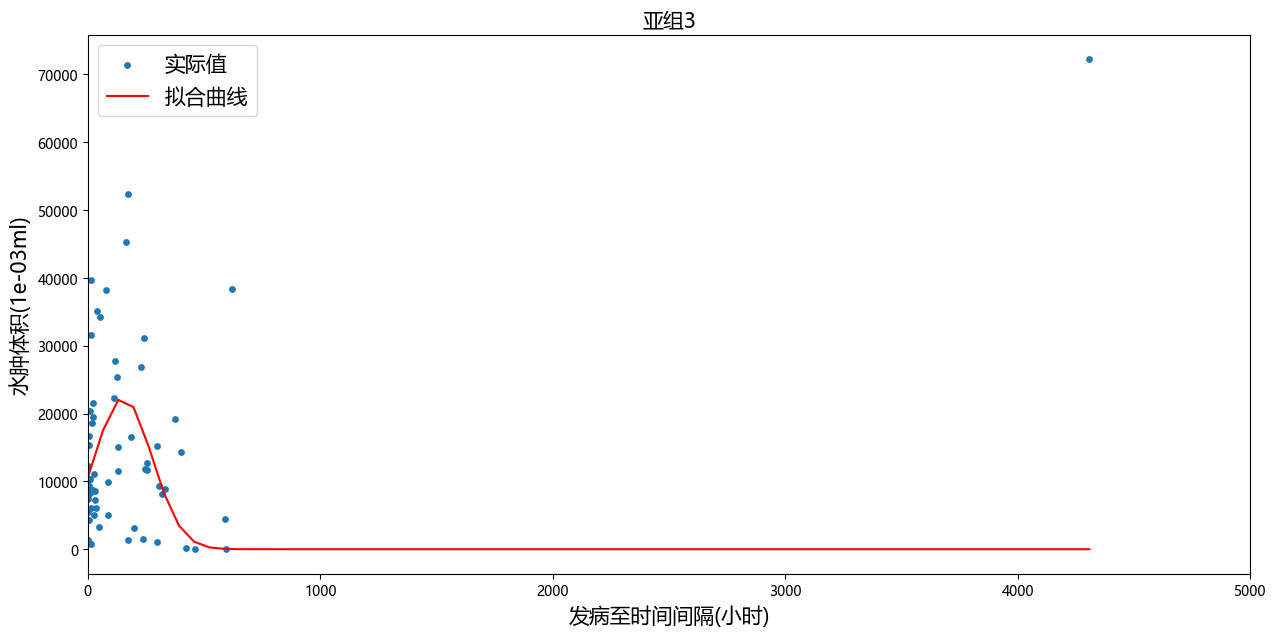

In [302]:
# 定义高斯分布函数
def gaussian_func(x, mu, sigma, A):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def gaussian_fit(df)
    # 获取拟合所需的自变量和目标变量
    x = df['发病至时间间隔'].values.flatten()
    y = df['水肿体积'].values.flatten()

    # 使用curve_fit进行高斯模型拟合
    p0 = [np.mean(x), np.std(x), np.max(y)]  # 初始参数猜测值
    params, _ = curve_fit(gaussian_func, x, y, p0=p0)

    # 提取拟合参数
    mu_gf, sigma_gf, A_gf = params

    # # 调整幅度参数和标准差参数
    # A_gf *= 2 # 增加幅度参数
    # sigma_gf /= 2# 减小标准差参数
    # # mu_gf = mu_gf - mu_gf*0.1

    # 生成拟合曲线
    x_gf = np.linspace(np.min(x), np.max(x), len(y))
    y_gf = gaussian_func(x_gf, mu_gf, sigma_gf, A_gf)
    return x_gf,y_gf


# 可视化拟合结果
plt.figure(figsize=(15,7))
plt.scatter(x, y,s=15,label='实际值')
plt.plot(x_gf, y_gf, color='red', label='拟合曲线')
plt.xlabel('发病至时间间隔(小时)',fontdict={'size':15})
plt.ylabel('水肿体积(1e-03ml)',fontdict={'size':15})
plt.xlim(0,5000)
plt.title('亚组3',fontdict={'size':15})
# plt.title('高斯模型拟合结果')
plt.legend(fontsize=15)
plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\亚组3.jpg')
plt.show()

array([1.00000000e+00, 2.33933333e+01, 2.39203056e+02, 1.00000000e+00,
       2.14597222e+01, 3.33572500e+02, 5.00000000e+00, 2.93638889e+01,
       2.97228056e+02, 4.60313889e+02, 3.00000000e+00, 2.08747222e+01,
       1.10791667e+02, 2.54615833e+02, 3.98882500e+02, 5.91468056e+02,
       3.00000000e+00, 3.95011111e+01, 8.77819444e+01, 2.29603056e+02,
       3.75892222e+02, 2.50000000e-01, 1.46158333e+01, 3.07304722e+02,
       1.00000000e+00, 4.61113889e+01, 2.38107500e+02, 8.00000000e+00,
       1.24219444e+01, 4.98933333e+01, 1.23095556e+02, 2.47160833e+02,
       4.00000000e+00, 2.83138889e+01, 1.27538611e+02, 3.00000000e+00,
       9.65333333e+00, 2.97957778e+02, 2.00000000e+00, 1.96525000e+01,
       1.86246944e+02, 2.00000000e+00, 1.41194444e+01, 1.17041667e+02,
       1.65716944e+02, 6.21402500e+02, 3.00000000e+00, 2.74216667e+01,
       1.29010278e+02, 3.19929722e+02, 4.30757250e+03, 2.00000000e+00,
       1.19247222e+01, 7.87722222e+01, 1.73574167e+02, 1.00000000e+00,
      

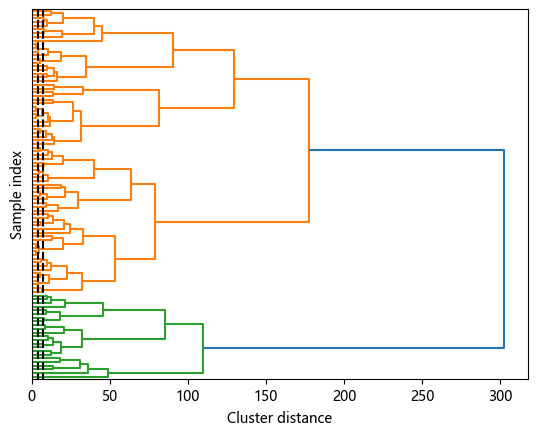

In [306]:
# 从SciPy中导入dendrogram函数和ward聚类函数
from scipy.cluster.hierarchy import dendrogram, ward
import numpy as np
path_reluster = r"C:\Users\10634\Desktop\20华为杯e题\question2\b\聚类特征.xlsx"
data = pd.read_excel(path_reluster)  # 请将'your_data.csv'替换为您的数据文件路径
x = data.iloc[:,1:21]
# 将ward聚类应用于数据数组X
# SciPy的ward函数返回一个数组，指定执行凝聚聚类时跨越的距离
linkage_array = ward(x)

# 调整linkage_array以适应横向显示
linkage_array[:, [0, 1]] = linkage_array[:, [1, 0]]

# 现在为包含簇之间距离的linkage_array绘制树状图
dendrogram(linkage_array, orientation='right')

# 在树中标记划分成两个簇或三个簇的位置

ax = plt.gca()
bounds = ax.get_ybound()
ax.plot([7.25, 7.25], bounds, '--', c='k')
ax.plot([4, 4], bounds, '--', c='k')

# ax.text(7.25, bounds[1], ' two clusters', ha='center', fontdict={'size': 5})
# ax.text(4, bounds[1], ' three clusters', ha='center', fontdict={'size': 5})
plt.ylabel("Sample index")
plt.xlabel("Cluster distance")
plt.yticks([])
# 反转y轴，使顺序与数据中的顺序相对应
plt.gca().invert_yaxis()
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\image\聚类树状图.jpg')
# 显示图形
plt.show()

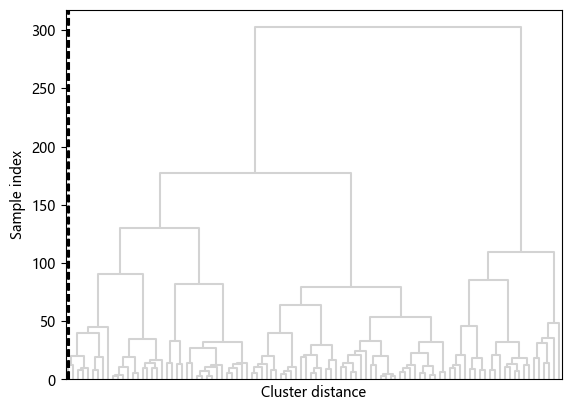

In [81]:
# 导入所需的库
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

# 读取数据
path_reluster = r"C:\Users\10634\Desktop\20华为杯e题\question2\b\聚类特征.xlsx"
data = pd.read_excel(path_reluster)
x = data.iloc[:, 1:21]

# 应用ward聚类
linkage_array = ward(x)

# 调整linkage_array以适应横向显示
linkage_array[:, [0, 1]] = linkage_array[:, [1, 0]]

# 绘制树状图，设置颜色为灰白色
dendrogram(linkage_array, orientation='top', color_threshold=0, above_threshold_color='lightgray')

# 在树中标记划分成两个簇或三个簇的位置
ax = plt.gca()
bounds = ax.get_ybound()
ax.plot([7.25, 7.25], bounds, '--', c='k')
ax.plot([4, 4], bounds, '--', c='k')

plt.ylabel("Sample index")
plt.xlabel("Cluster distance")
plt.xticks([])
# plt.gca().invert_yaxis()

# 保存图像为灰白色
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\image\聚类树状图.jpg', bbox_inches='tight', dpi=300, facecolor='white')

# 显示图形
plt.show()

In [355]:
dfn0

,ID,date,vol,time
0,sub002,2016-04-06 21:21:03,23526,3.000000
1,sub002,2016-04-07 09:16:27,23390,14.923333
2,sub002,2016-04-09 15:34:22,28415,69.221944
3,sub002,2016-04-25 10:22:02,34868,448.016389
4,sub002,2016-05-23 09:32:34,0,1119.191944
...,...,...,...,...
118,sub098,2018-06-12 22:32:20,39868,2.500000
119,sub098,2018-06-14 14:47:44,29007,42.756667
120,sub098,2018-06-20 15:41:45,26426,187.656944
121,sub098,2018-07-06 14:32:09,40666,570.496944


In [359]:
lst = []
for i in [dfn0,dfn1,dfn2,dfn3]:
    panel_data = i
    panel_data.columns = ['ID','date','vol','time']
    model_formula = 'vol ~ time + C(ID)'
    model = smf.mixedlm(model_formula, panel_data, groups=panel_data.index.get_level_values(0))
    result = model.fit()
    df = pd.concat([i['ID'],i['vol'],result.fittedvalues],axis=1)
    lst.append(df)
df_random_pre = pd.concat(lst,axis=0)
df_random_pre.columns = ['ID','vol','pre']
df_random_pre['error'] = abs((df_random_pre['vol'] - df_random_pre['pre']) / 1000)
df_random_pre.to_excel(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\random_error.xlsx')

D:\anaconda\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
D:\anaconda\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
D:\anaconda\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


D:\anaconda\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


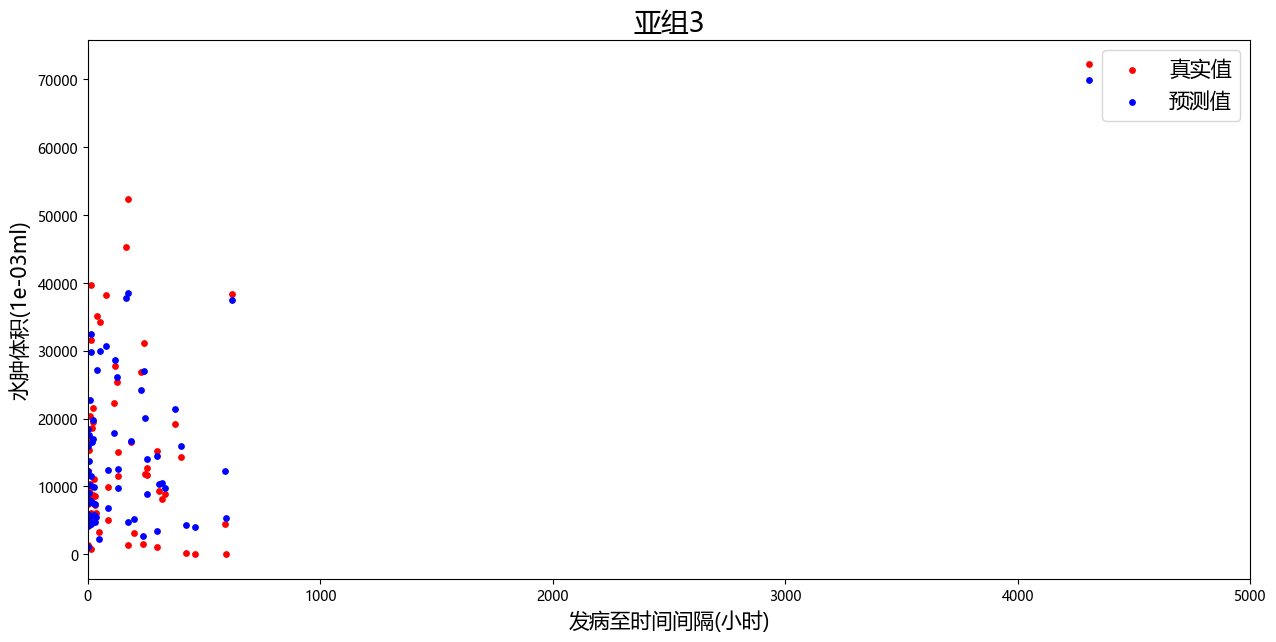

In [346]:
# 进行随机效应模型建模
panel_data = dfn3.iloc[:,2:-1]
panel_data.columns = ['ID','date','vol','time']
model_formula = 'vol ~ time + C(ID)'
model = smf.mixedlm(model_formula, panel_data, groups=panel_data.index.get_level_values(0))
result = model.fit()

import matplotlib.pyplot as plt

# 获取模型预测值
panel_data['pre'] = result.fittedvalues

# 绘制观测值和预测值的对比图
plt.figure(figsize=(15,7))
plt.scatter(panel_data['time'],panel_data['vol'],s=15, c='red',label='真实值')
plt.scatter(panel_data['time'],panel_data['pre'],s=15, c='blue',label='预测值')
plt.xlabel('发病至时间间隔(小时)',fontdict={'size':15})
plt.ylabel('水肿体积(1e-03ml)',fontdict={'size':15})
plt.title('亚组3',fontdict={'size':20})
plt.xlim(0,5000)
plt.legend(fontsize=15)
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\b\image\随机效应模型亚组3.jpg')
plt.show()
# plt.plot(panel_data['time'],panel_data['pre'], label='预测值')

## c

In [ ]:
col = ['ID','Hemostasis','Hypocranial','Antihypertensive','Sedation','stomach','Nutritional','ED_vol',]

In [139]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

path = r"C:\Users\10634\Desktop\20华为杯e题\question2\c\治疗方案和水肿体积.xlsx"
df = pd.read_excel(path,sheet_name='体积变化（第三次检查）')
df = df[~(pd.isna(df['hmvol3']) | pd.isna(df['edvol3']))]
col = ['ID','Hemostasis','Hypocranial','Antihypertensive',
       'Sedation','stomach','Nutritional','hmvol','edvol','hmvol3','edvol3','治疗方案数']
df.columns = col
df['ed_change'] = (df['edvol3'] - df['edvol']) / 1000
df['hm_change'] = (df['hmvol3'] - df['hmvol']) / 1000
# 将大于0的数变为0，小于0的数变为1
df['ed_change'] = df['ed_change'].apply(lambda x: 0 if x > 0 else 1)
par = ' + '.join(col[1:7])

# 多元线性回归分析
model = ols('ed_change ~ {}'.format(par), data=df).fit() # 水肿
print(model.summary())
print('-'*150)
model = ols('hm_change ~ {}'.format(par), data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ed_change   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.452
Date:                Mon, 25 Sep 2023   Prob (F-statistic):              0.205
Time:                        18:58:08   Log-Likelihood:                -49.192
No. Observations:                  88   AIC:                             112.4
Df Residuals:                      81   BIC:                             129.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.6424      0.320  

In [136]:
for i in range(1,7):
    formula = 'ed_change ~ C({})'.format(col[i]) # 单因素方差分析
    anova_model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(anova_model, typ=2)
    print(anova_table)

                  sum_sq    df         F    PR(>F)
C(Hemostasis)   0.060606   1.0  0.299652  0.585519
Residual       17.393939  86.0       NaN       NaN
                   sum_sq    df         F    PR(>F)
C(Hypocranial)   1.336898   1.0  7.133378  0.009047
Residual        16.117647  86.0       NaN       NaN
                        sum_sq    df         F    PR(>F)
C(Antihypertensive)   0.454545   1.0  2.299465  0.133086
Residual             17.000000  86.0       NaN       NaN
                sum_sq    df         F    PR(>F)
C(Sedation)   0.033081   1.0  0.163304  0.687136
Residual     17.421464  86.0       NaN       NaN
               sum_sq    df         F    PR(>F)
C(stomach)   0.002165   1.0  0.010666  0.917984
Residual    17.452381  86.0       NaN       NaN
                   sum_sq    df         F    PR(>F)
C(Nutritional)   0.216450   1.0  1.079859  0.301642
Residual        17.238095  86.0       NaN       NaN


In [137]:
# 多因素方差分析
formula = 'ed_change ~ C({}) + C({})+ C({})+ C({})+ C({})+ C({})'.format(col[1],col[2],col[3],col[4],col[5],col[6])

anova_model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
print(anova_table)

                        sum_sq    df         F    PR(>F)
C(Hemostasis)         0.005065   1.0  0.026033  0.872221
C(Hypocranial)        0.984065   1.0  5.057826  0.027230
C(Antihypertensive)   0.026717   1.0  0.137318  0.711929
C(Sedation)           0.032078   1.0  0.164874  0.685779
C(stomach)            0.038769   1.0  0.199264  0.656507
C(Nutritional)        0.235967   1.0  1.212806  0.274039
Residual             15.759586  81.0       NaN       NaN


## d

C:\Users\10634\AppData\Local\Temp\ipykernel_15584\2630188270.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


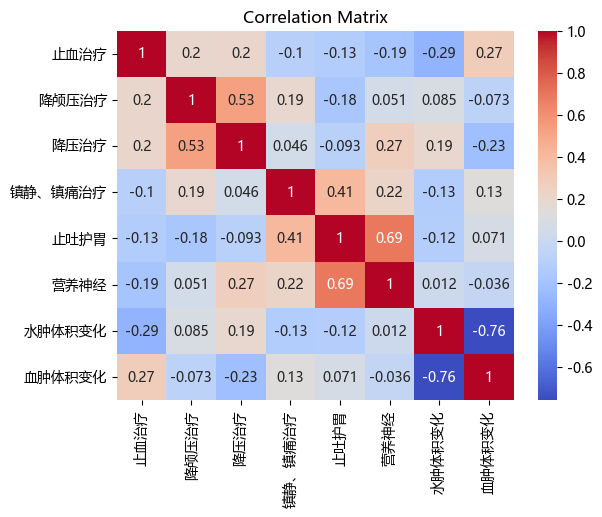

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
path = r"C:\Users\10634\Desktop\20华为杯e题\question2\c\治疗方案和水肿体积.xlsx"
df = pd.read_excel(path,sheet_name='体积变化（第三次检查）')
df = df[~(pd.isna(df['hmvol3']) | pd.isna(df['edvol3']))]
df['ed_change'] = (df['edvol3'] - df['edvol']) / 1000
df['hm_change'] = (df['hmvol3'] - df['hmvol']) / 1000
df = pd.concat([df.iloc[:,0:7],df['ed_change'],df['hm_change']],axis=1)
df = df[df['ed_change'] < 0]
df['ed_change'] = abs(df['ed_change'])
df.rename(columns={'ed_change':'水肿体积变化','hm_change':'血肿体积变化'},inplace=True)
# 计算相关系数
correlation_matrix = df.corr()

# 可视化相关性矩阵
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
# plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\d\热力图.jpg')
plt.show()

### 探索：治疗方案数

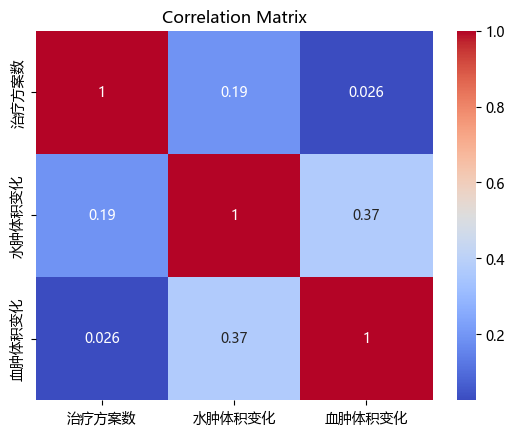

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
path = r"C:\Users\10634\Desktop\20华为杯e题\question2\c\治疗方案和水肿体积.xlsx"
df = pd.read_excel(path,sheet_name='体积变化（第三次检查）')
df = df[~(pd.isna(df['hmvol3']) | pd.isna(df['edvol3']))]
df['ed_change'] = (df['edvol3'] - df['edvol']) / 1000
df['hm_change'] = (df['hmvol3'] - df['hmvol']) / 1000
df = pd.concat([df['治疗方案数'],df['ed_change'],df['hm_change']],axis=1)
# df = df[df['ed_change'] < 0]
# df['ed_change'] = abs(df['ed_change'])
df.rename(columns={'ed_change':'水肿体积变化','hm_change':'血肿体积变化'},inplace=True)
# 计算相关系数
correlation_matrix = df.corr()

# 可视化相关性矩阵
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig(r'C:\Users\10634\Desktop\20华为杯e题\question2\d\热力图(治疗方案数).jpg')
plt.show()

# 三

In [141]:
import torch
import torchvision
import numpy as np
import sys



In [155]:
batch_size = 256#小批量进行读取
num_inputs = 784
num_outputs = 10
#随机初始化参数
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)


In [152]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)#行元素求和
    return X_exp / partition  # 这里应用了广播机制

def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)


def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述

# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n


In [150]:
from sklearn.model_selection import train_test_split

path = r"C:\Users\10634\Desktop\20华为杯e题\quesiton3\3a.xlsx"
train = pd.read_excel(path,sheet_name='train')
x,y = train.iloc[:,1:-1],train['90天mRS']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)
xtrain

,年龄,性别,脑出血前mRS评分,高血压病史,卒中病史,糖尿病史,房颤史,冠心病史,吸烟史,饮酒史,...,Hemo_NCCT_original_firstorder_Mean,Hemo_NCCT_original_firstorder_Median,Hemo_NCCT_original_firstorder_Minimum,Hemo_NCCT_original_firstorder_Range,Hemo_NCCT_original_firstorder_RobustMeanAbsoluteDeviation,Hemo_NCCT_original_firstorder_RootMeanSquared,Hemo_NCCT_original_firstorder_Skewness,Hemo_NCCT_original_firstorder_Uniformity,Hemo_NCCT_original_firstorder_Variance,随访1相对体积增加比率
55,71,2,0,1,0,1,0,0,0,0,...,139.720239,137.090218,73.072621,189.780191,21.829095,143.612583,0.268005,0.099076,1102.828692,50.521046
88,65,2,0,1,0,0,0,0,0,0,...,158.013874,158.098718,89.608229,150.861257,24.603262,161.739334,0.031944,0.078529,1191.227548,48.417464
26,63,1,0,1,1,1,0,1,0,0,...,155.247361,155.234506,78.612068,162.530596,23.135856,158.955184,0.032700,0.081475,1165.007647,50.355069
42,82,2,0,1,0,1,0,0,0,0,...,157.799152,157.913209,74.595961,164.952582,24.115740,161.543820,-0.052103,0.083806,1195.833488,49.587260
69,84,2,0,1,1,0,0,0,0,0,...,141.365739,135.755640,68.311758,241.849924,23.033781,147.199878,1.119540,0.119011,1683.531857,73.089686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,48,1,0,1,0,1,0,0,0,0,...,129.480857,129.058063,65.292447,159.824757,19.158857,132.803814,0.136462,0.092310,871.560767,45.491272
71,91,2,0,1,0,0,1,1,0,0,...,150.334706,148.076121,81.319946,150.789363,21.192886,153.709432,0.201473,0.080846,1026.065693,48.415572
14,81,1,0,1,1,1,0,0,1,0,...,154.133564,154.516900,80.981876,159.777645,27.315908,158.671771,-0.009872,0.078264,1419.575601,51.968823
92,56,1,0,1,0,0,0,0,1,1,...,125.245699,125.028618,70.764422,120.327322,17.561536,127.916430,0.089040,0.079644,676.127796,38.500492


In [172]:
# 定义神经网络模型
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [173]:
import torch
import torch.nn as nn
import torch.optim as optim

path = r"C:\Users\10634\Desktop\20华为杯e题\quesiton3\3a.xlsx"
train = pd.read_excel(path,sheet_name='train')
x,y = train.iloc[:,1:-1],train['90天mRS']

x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)  # Change 512 to num_feature
        self.layer_2 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x


num_feature = 10
num_class = 6

# Create the model
model = MulticlassClassification(num_feature=num_feature, num_class=num_class)
print(model)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(x)

    # Compute the loss
    loss = criterion(outputs, y)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

MulticlassClassification(
  (layer_1): Linear(in_features=10, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x105 and 10x512)